In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=0.5)

Importing the train & test data into jupyter environment.

In [3]:
# Load the data into DataFrames
train_users = pd.read_csv('D:/Study/Springboard/Capestone Project/Airbnb New User Bookings/Data/train_users_2.csv')
test_users = pd.read_csv('D:/Study/Springboard/Capestone Project/Airbnb New User Bookings/Data/test_users.csv')

In [4]:
print("We have", train_users.shape[0], "users in the training set and", 
      test_users.shape[0], "in the test set.")
print("In total we have", train_users.shape[0] + test_users.shape[0], "users.")

We have 213451 users in the training set and 62096 in the test set.
In total we have 275547 users.


We merged both train & test data, so that we can look at them together at a time

In [6]:
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

users.head()

C:\Users\Abhilash Naik\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,id,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,gxn3p5htnn,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,820tgsjxq7,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,4ft3gnwmtx,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,bjjt8pjhuk,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,87mebub9p4,en,Web,0,basic,20091208061105


### Missing values

Usually the missing values are represented as 'NaN' or 'Blanks'. But we can see 'unknown' in gender column. We need to convert them to NaN first.

In [8]:
users.gender.replace('-unknown-', np.nan, inplace=True)

Let's check the percentage of NaN in the whole dataframe.

In [9]:
users_nan = (users.isnull().sum() / users.shape[0]) * 100
users_nan[users_nan > 0].drop('country_destination')

age                        42.412365
date_first_booking         67.733998
first_affiliate_tracked     2.208335
gender                     46.990169
dtype: float64

We have quite a lot of *NaN* in the `age` and `gender` wich will yield in lesser performance of the classifiers we will build. The feature `date_first_booking` has a 67% of NaN values because this feature is not present at the tests users, and therefore, we won't need it at the *modeling* part.

### Outliers

In [10]:
users.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

There seems to be some outliers present in age column. We can see std to be 142 and max is 2014. Let's explore a little more.

In [16]:
print(sum(users.age > 115))
print(sum(users.age < 18))

830
188


There are 830 users with age more than 115 and 188 users with age less than 18

In [18]:
users[users.age > 122]['age'].describe()

count     830.000000
mean     2002.620482
std        94.201344
min       132.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

In [19]:
users[users.age < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

The inconsistency in these numbers is caused by the value '2014' in age column. We can set up a age window/range for our analysis.

In [20]:
users.loc[users.age > 95, 'age'] = np.nan
users.loc[users.age < 13, 'age'] = np.nan

Let's update the data types for each variable.

In [21]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

for categorical_feature in categorical_features:
    users[categorical_feature] = users[categorical_feature].astype('category')

In [22]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')

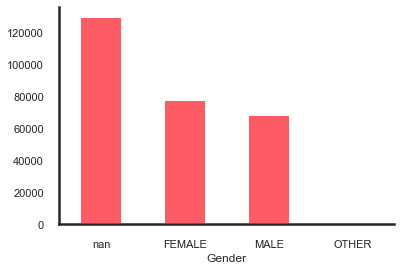

In [26]:
users.gender.value_counts(dropna=False).plot(kind='bar', color='#FD5C64', rot=0)
plt.xlabel('Gender')
sns.despine()

At this plot we can see the ammount of missing data in perspective. Also, notice that there is a slight difference between user gender.

Next thing it might be interesting to see if there is any gender preferences when travelling:

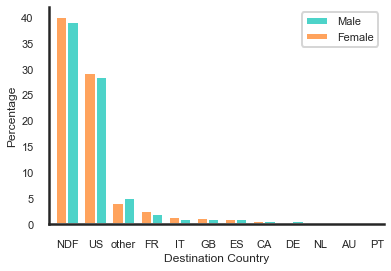

In [27]:
women = sum(users['gender'] == 'FEMALE')
men = sum(users['gender'] == 'MALE')

female_destinations = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

There are no big differences between the 2 main genders, so in this plot it's not really ussefull except to know the relative destination frecuency of the countries. Let's see it clear in next visual.

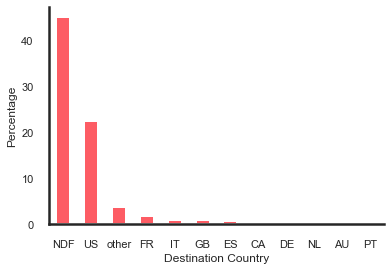

In [28]:
destination_percentage = users.country_destination.value_counts() / users.shape[0] * 100
destination_percentage.plot(kind='bar',color='#FD5C64', rot=0)
# Using seaborn can also be plotted
# sns.countplot(x="country_destination", data=users, order=list(users.country_destination.value_counts().keys()))
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

The first thing we can see that if there is a reservation, it's likely to be inside the US. But there are 45% of people that never did a reservation.

So far we couldn't identify any relation of gender with reservation. Lets check age.

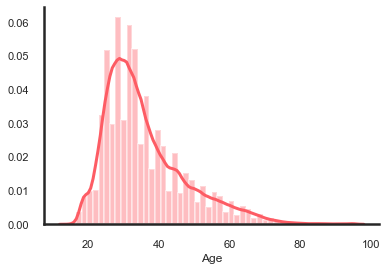

In [29]:
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

The common age to travel is between 25 and 45. Let's see if, for example, older people travel in a different way. Let's pick an arbitrary age to split into two groups.

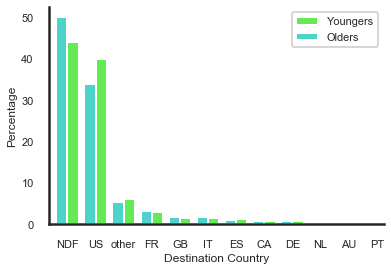

In [30]:
age = 45

younger = sum(users.loc[users['age'] < age, 'country_destination'].value_counts())
older = sum(users.loc[users['age'] > age, 'country_destination'].value_counts())

younger_destinations = users.loc[users['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = users.loc[users['age'] > age, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Youngers', rot=0)
older_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='Olders', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

We can see that the young people tends to stay in the US, and the older people choose to travel outside the country. However, there are no big differences between them and we must remember that we do not have the 42% of the ages. 

The first thing I thought when reading the problem was the importance of the native lenguage when choosing the destination country. So let's see how manny users use english as main language:

In [34]:
print((sum(users.language == 'en') / users.shape[0])*100)

96.3675888323952


With the 96% of users using English as their language, it is understandable that a lot of people stay in the US. Someone maybe thinking, if the language is important, why not travel to GB? We need to remember that there is also a lot of factor we are not acounting so making assumpions or predictions like that might be dangerous.

Let's check the dates now.

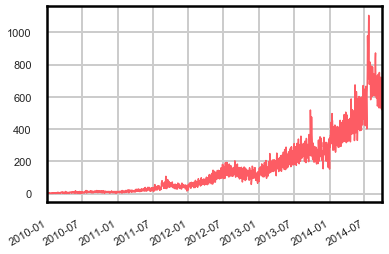

In [38]:
sns.set_style("whitegrid", {'axes.edgecolor': '0'})
sns.set_context("poster", font_scale=0.5)
users.date_account_created.value_counts().plot(kind='line', linewidth=1.5, color='#FD5C64')

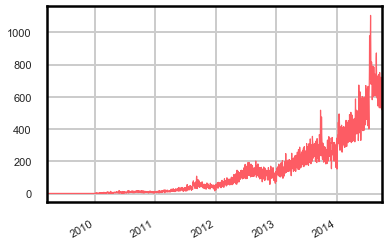

In [39]:
users.date_first_active.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')

We can see both 'date_account_created' & 'date_first_active' follows similar pattern. We can figure out how Airbn has gained popularity in the past years.

Let's check whether any particular day draws more customer to the portal.

In [41]:
weekdays = []
for date in users.date_account_created:
    weekdays.append(date.weekday())
weekdays = pd.Series(weekdays)

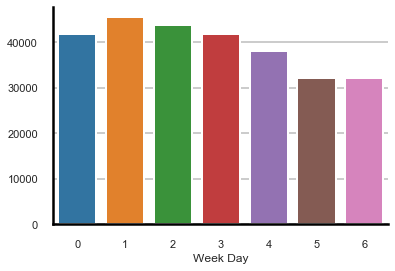

In [42]:
sns.barplot(x = weekdays.value_counts().index, y=weekdays.value_counts().values, order=range(0,7))
plt.xlabel('Week Day')
sns.despine()

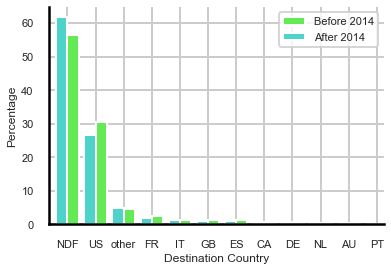

In [43]:
date = pd.to_datetime(20140101, format='%Y%m%d')

before = sum(users.loc[users['date_first_active'] < date, 'country_destination'].value_counts())
after = sum(users.loc[users['date_first_active'] > date, 'country_destination'].value_counts())
before_destinations = users.loc[users['date_first_active'] < date, 
                                'country_destination'].value_counts() / before * 100
after_destinations = users.loc[users['date_first_active'] > date, 
                               'country_destination'].value_counts() / after * 100
before_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Before 2014', rot=0)
after_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='After 2014', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()